<span style="font-size:10pt">AI-ML / v1.0 March 2025 / Jean-Luc.charles@mailo.com / CC BY-SA 4.0 /</span>

<div style="color:brown;font-family:arial;font-size:26pt;font-weight:bold;text-align:center"> 
The question of the training repetability </div><br>
<hr>
<div style="color:blue;font-family:arial;font-size:22pt;font-weight:bold;text-align:center"> 
Illustration with the simple image classification problem:<br> the classification of the MNIST hand-written digits</div>
<hr>
Expected duration : 20 minutes

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:12pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for your Python projects: a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).</span></div>

All the notebooks of this directory must be loaded with `uv run jupyter notebook` or `uv run jupyter lab` which ensures the actication of the <b><span style="color: rgb(200, 151, 102);">Study-00</span></b> PVE located in the .venv foldr<br>

## Targeted objectives
- Observe the stochastic nature of a NN training process.
- Learn how to make the training reproducible

## 1 - Import the Python modules
The **keras** module which allows high-level manipulation of **tensorflow** objects is integrated in the **tensorflow** (tf) module since version 2. <br>
The **tf.keras** module documentation to consult is here: https://www.tensorflow.org/api_docs/python/tf/keras.

Importing the `tensorflow` module in the cell below may generate some warning messages...<br>
if errors appear they must be corrected, possibly by recreating your <b><span style="color: rgb(200, 51, 102);">pyml</span> PVE</b>:

In [1]:
import os, sys, cv2

# Delete the (numerous) warning messages from the **tensorflow** module:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

E0000 00:00:1740304547.211143  461230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740304547.215031  461230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Python    : 3.12.3
tensorflow: 2.18.0 with keras 3.8.0
numpy     : 2.0.2
OpenCV    : 4.11.0


Embedding matplotlib plots in the notebook:

In [2]:
%matplotlib inline

## 2 - Load the MNIST dataset (images and labels)

### ▸ The MNIST images bank

We use the labeled images from the MNIST dataset available on the Internet (http://yann.lecun.com/exdb/mnist/).

The MNIST dataset contains 70,000 grayscale images of 28 $\times$ 28 pixels, representing handwritten digits: each image is a 28$\times$28 matrix of 784 `uint8` numbers (positive integers on 8 bits, coding a value in the interval [0, 255]).<br>
The 70,000 MNIST images are grouped in a set of **60,000 training images** and a set of **10,000 validtion images**.

<div class="alert alert-block alert-danger">
The evaluation of the performance of a trained network must always be done with a data set different from the training set: this is why the MNIST bank offers 10,000 validation images <b>different</b> from the 60,000 workout pictures.
</div>
<br>Example of MNIST images:
<p style="text-align:center; font-style:italic; font-size:12px;">
<img src="img/MNIST_digits_sample.png" width="500"><br>
[image credit: JLC]
</p>

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [3]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [4]:
print("im_train.shape :", im_train.shape, ", dtype:", im_train.dtype,)
print("lab_train.shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("im_valid.shape  :", im_valid.shape,  ", dtype:", im_valid.dtype,)
print("lab_valid.shape :", lab_valid.shape,  ", dtype:", lab_valid.dtype)

im_train.shape : (60000, 28, 28) , dtype: uint8
lab_train.shape: (60000,) , dtype: uint8
im_valid.shape  : (10000, 28, 28) , dtype: uint8
lab_valid.shape : (10000,) , dtype: uint8


### ▸ Images and labels visualisation:

With the `imshow` function of the `matplotlib.pyplot` module, we display (in gray tone) the 600th image of the `im_train` array.<br>

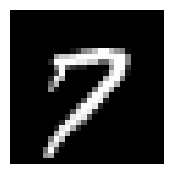

In [5]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[599], cmap='gray')
plt.axis('off');

We can check that the associated label in the `im_train` table corresponds to the image....

In [6]:
print(lab_train[599])

7


The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images:

In [7]:
from utils.tools import plot_images
help(plot_images)

Help on function plot_images in module utils.tools:

plot_images(image_array: numpy.ndarray, R: int, C: int, r: int = 0, figsize: tuple = None, reverse: bool = False)
    Plot the images from image_array on a R x C grid, starting at image rank r.
    Arguments:
       image_array: an array of images
       R: the number of rows
       C: the number of columns
       r: the starting rank in the array image_array (default: 0)
       figsize: the sise of the display (default: (C//2+1, R//2+1))
       reverse: wether to reverse video the image or not (default: False)



Let's display the training images in a 4 x 6 grid beginning with the 600th image:

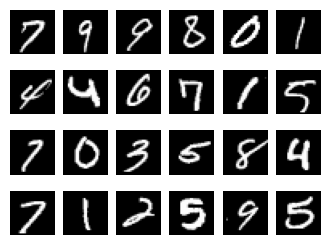

In [8]:
plot_images(im_train, 4, 6, 599)

#### Define important parameters

To avoid "hard writing" the **number of images**, the **dimension** of the images and the **number of classes** these parameters are retrieved from the dataset:
- the `shape` attribute of `im_train` and `im_valid` contains the number of training and validation images,
- the `size` attribute of the any image gives the number of pixels (784),<br>
- the transformation of the `lab_train` array into a Python `set` gives the set of labels to recognize, whose size is the number of classes.

In [9]:
nb_im_train = im_train.shape[0]    # number of training images
nb_im_valid = im_valid.shape[0]    # number of validation images
nb_pixel    = im_train[0].size     # number of elements (pixels) of the dataset images
nb_classe   = len(set(lab_train))  # number of classes to classify (the ten digits from 0 to 9)

Checking:

In [10]:
print(f"{nb_im_train} traing images and {nb_im_valid} test images")
print(f"{nb_pixel} pixels in each image")
print(f"{nb_classe} classes to recognize (the digits from 0 to 9)")

60000 traing images and 10000 test images
784 pixels in each image
10 classes to recognize (the digits from 0 to 9)


## 3 - Pre-process MNIST images and labels

Two treatments must be applied to the data from the MNIST database:
- __on images__: transform the matrices of  28$\,\times\,$28 pixels (`uint8`integers) into **normalized** vectors $(V_i)_{i=0..783}$ of 784 real values $V_i$ with $ 0 \leqslant V_i \leqslant 1$;
- __on labels__: transform scalar numbers into *one-hot* vectors.

### Transform images into normalized vectors

We define `x_train` and `x_valid` containing the data of the arrays `im_train` and `im_valid` *flattened* as normalized vectors (values between 0 and 1):

In [11]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_valid = im_valid.reshape(nb_im_valid, nb_pixel)/im_valid.max()

Check the dimensions of the `x_train` and `x_valid` arrays as well as their *min* and *max* values:

In [12]:
print(f"min,max of x_train: ({x_train.min():f}, {x_train.max():f})")
print(f"min,max of x_train: ({x_valid.min():f}, {x_valid.max():f})")

min,max of x_train: (0.000000, 1.000000)
min,max of x_train: (0.000000, 1.000000)


### *one-hot* encoding of labels:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train` and `y_valid` arrays containing the *hot-one* encoded version of `lab_train` and `lab_valid`:

In [13]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [14]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


# Simple dense network to build
Now we will build this simple **dense network**
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/Simple-DNN.png" alt="archiNetwork.png" style="width:900px;"><br>
    [image credit: JLC]
</p>

- an **input layer** of 784 values in the range [0 ; 1.]<br>
(the pixels of the MNIST 28 $\times$ 28 images put in the form of a vector of 784 normalized `float` numbers),
- one **hidden layer** of 784 neurons using the `relu` activation function,
- one **output layer** with 10 neurons, for the classification of images into 10 classes associated with the digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems .

Remarks :
- Each neuron of the first hidden layer receives 785 inputs: the 784 values $x_i$ of the pixels of the image plus the bias.
- $\leadsto$ There are therefore 785 unknowns for each neuron: the 784 weights $w_i$ assigned to each input $x_i$, plus the weight $b$ assigned to input $-1$.
- $\leadsto$ there are therefore 785 $\times$ 784 unknowns for the hidden layer and 785 $\times$ 10 unknowns for the output layer: i.e. a total of 623290 unknowns (also called the **parameters** of the model) whose value must be optimized by the training algorithm.

## 3 - Build the Dense Neural Network

We will now build the dense **sequential** neural network in Python **5 lines** using the **keras** module.

In [45]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

'''# set the seed of the random generators used by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()'''

# the 5 lines to build the neural network:
model = Sequential()
model.add(Input(shape=(nb_pixel,), name='input'))
model.add(Dense(nb_pixel, activation='relu', name='c1'))
model.add(Dense(nb_classe, activation='softmax', name='c2'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',  
              metrics=['accuracy'])

Look at the number of parameters and the memory size of the model:

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ c1 (Dense)                      │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2 (Dense)                      │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

The `plot_model` (see [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)) 
show the graphical description of the model:

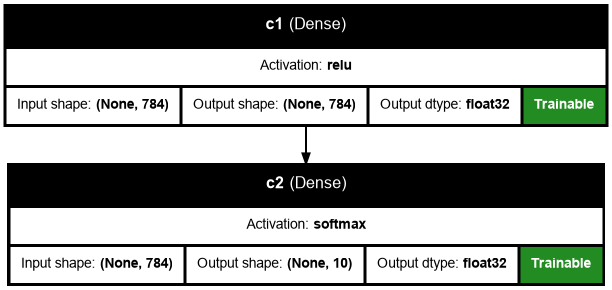

In [47]:
tf.keras.utils.plot_model(model, 
                          show_shapes=True,
                          show_dtype=True, 
                          show_layer_names=True,
                          dpi=72,
                          show_layer_activations=True,
                          show_trainable=True)

## 5 - A first "naive" Network training 

If necessary, consult the documentation of the `fit` method on the page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Complete the cell below to train the DNN with the `fit` method of the `model` object using the arguments:
- `x_train`: the 60000 flattened and normalized images
- `y_train`: the 60000 *one-hot* encoded labels.
- `epochs=15`: repeat the training 15 times.
- `batch_size=128`: split the input data set (the 60000 images) into "batches" of size `batch_size` (here: batches of 128 images).<br>
Updating network weights is done after each batch of `batch_size` images.<br>
The value of `batch_size` (by default: 32) is a parameter that influences the quality of the training but also its memory footprint: you can later try different values (64, 128, 256 ...) and observe how the quality of the training evolves).

Name `hist` the data returned by the `fit` method.

In [48]:
# define the key to reload the initial state & structure of the network:
key = 'dense1_init'

# define the path to be used:
path = os.path.join('models', key)

# load the network initial structure and weights:
#model = tf.keras.models.load_model(path) 

'''# Deterministic tensorflow training: 
# set the seed of the random generators inolved by tensorflow:
tf.keras.utils.set_random_seed(SEED)
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.config.experimental.enable_op_determinism() '''

# train the DNN:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid), 
                 epochs=15, 
                 batch_size=128)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8785 - loss: 0.4331 - val_accuracy: 0.9630 - val_loss: 0.1200
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9705 - loss: 0.1044 - val_accuracy: 0.9732 - val_loss: 0.0889
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9810 - loss: 0.0655 - val_accuracy: 0.9748 - val_loss: 0.0819
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9863 - loss: 0.0441 - val_accuracy: 0.9795 - val_loss: 0.0680
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9907 - loss: 0.0309 - val_accuracy: 0.9789 - val_loss: 0.0681
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9935 - loss: 0.0224 - val_accuracy: 0.9819 - val_loss: 0.0598
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9961 - loss: 0.0152 - val_accuracy: 0.9810 - val_loss: 0.0619
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9977 - loss: 0.0100 - val_accuracy: 0.

### Plot of the `loss` and `accuracy` curves

The `plot_loss_accuracy` function of the `utils.tools` module (found in the notebook directory) plots the "Model accuracy" and "Model loss" curves with the data stored in `hist`.<br> Import and use the `plot_loss_accuracy` function to plot these curves:

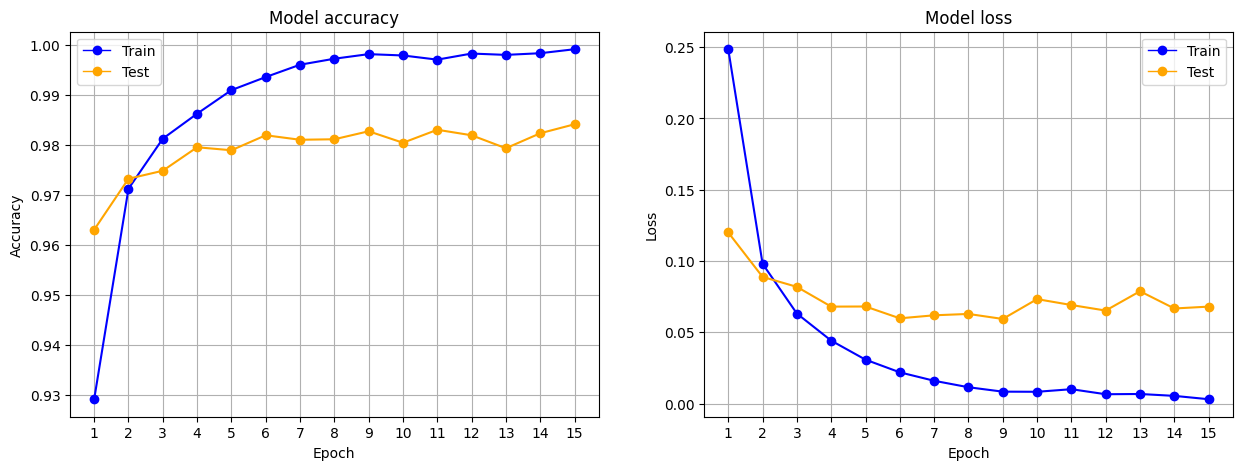

In [49]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

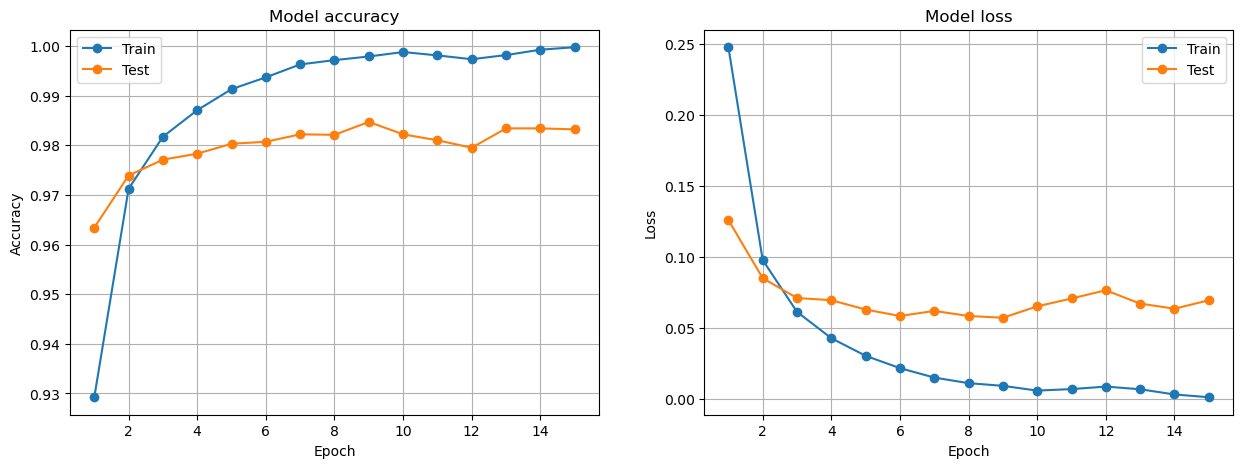

In [26]:
plot_loss_accuracy(hist)

the precision calculated with the test data tends towards a limit close to 98.3 %. You might think that increasing the value of `epochs` would improve the precision of the network... but you run the risk of over-training the network (*over-fit*)...

## 7 - Train the Network while measuring its performance at each *epoch* and managing the *over-fit*

The `Keras` module offers tools to automatically stop the training by monitoring for example the growth of precision (accuracy) from one `epoch` to another.<br>
You define the parameters of the `EarlyStopping` (cf [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) *callback* and pass it to the method `fit` via the `callbacks` argument:

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# define the parameters of the `EarlyStopping`:
callbacks_list = [ 
    EarlyStopping(monitor='val_accuracy',  # the parameter to monitor
                  patience=2,              # accept that the parameter decreases only twice
                  restore_best_weights=True,
                  verbose=1)
]

# define the key to reload the initial state & structure of the network:
key = 'dense1_init'

# define the path to be used:
path = os.path.join('models', key)

# load the network initial structure and weights:
model = tf.keras.models.load_model(path) 

# Deterministic tensorflow training: 
# set the seed of the random generators inolved by tensorflow:
tf.keras.utils.set_random_seed(SEED)
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.config.experimental.enable_op_determinism() 

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

Epoch 1/15
469/469 [==============================] - 10s 21ms/step - loss: 0.2479 - accuracy: 0.9292 - val_loss: 0.1263 - val_accuracy: 0.9634
Epoch 2/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0981 - accuracy: 0.9712 - val_loss: 0.0853 - val_accuracy: 0.9739
Epoch 3/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0714 - val_accuracy: 0.9771
Epoch 4/15
469/469 [==============================] - 7s 16ms/step - loss: 0.0430 - accuracy: 0.9871 - val_loss: 0.0698 - val_accuracy: 0.9783
Epoch 5/15
469/469 [==============================] - 9s 19ms/step - loss: 0.0306 - accuracy: 0.9913 - val_loss: 0.0632 - val_accuracy: 0.9803
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.0587 - val_accuracy: 0.9807
Epoch 7/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.0622 - val_accuracy: 0.982

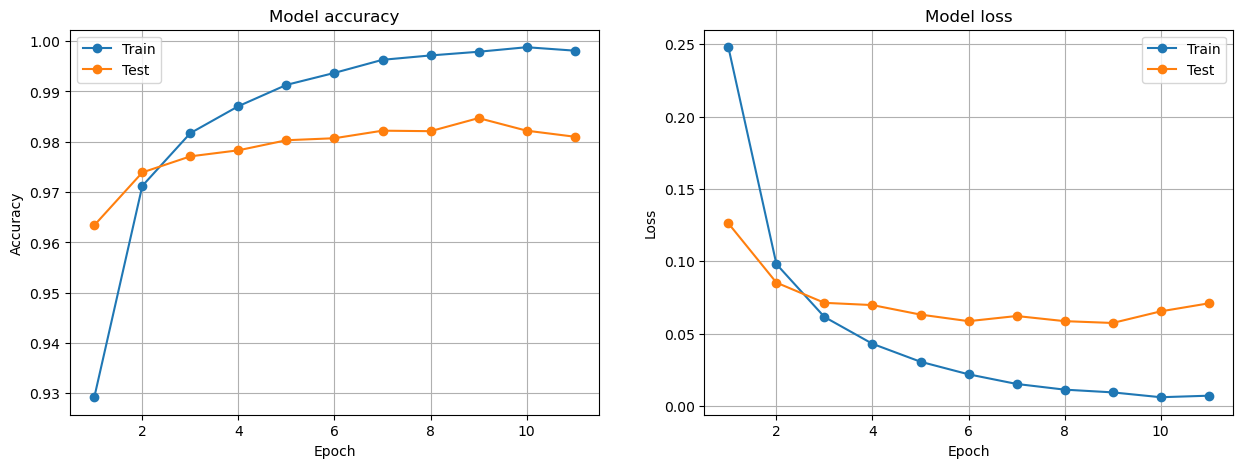

In [28]:
plot_loss_accuracy(hist)

Instead of monitoring the decrease of `val_accuracy` you can also monitor the increase of `val_loss`, which may be a prefeerd strategy (can you guess why ?):

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# define the parameters of the `EarlyStopping`:
callbacks_list = [ 
    EarlyStopping(monitor='val_loss',  # the parameter to monitor
                  patience=2,          # accept that 'val_loss' increases twice
                  restore_best_weights=True,
                  verbose=1)
]

# define the key to reload the initial state & structure of the network:
key = 'dense1_init'

# define the path to be used:
path = os.path.join('models', key)

# load the network initial structure and weights:
model = tf.keras.models.load_model(path) 

# Deterministic tensorflow training: 
# set the seed of the random generators inolved by tensorflow:
tf.keras.utils.set_random_seed(SEED)
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.config.experimental.enable_op_determinism() 

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

Epoch 1/15
469/469 [==============================] - 5s 11ms/step - loss: 0.2479 - accuracy: 0.9292 - val_loss: 0.1263 - val_accuracy: 0.9634
Epoch 2/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0981 - accuracy: 0.9712 - val_loss: 0.0853 - val_accuracy: 0.9739
Epoch 3/15
469/469 [==============================] - 12s 26ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0714 - val_accuracy: 0.9771
Epoch 4/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0430 - accuracy: 0.9871 - val_loss: 0.0698 - val_accuracy: 0.9783
Epoch 5/15
469/469 [==============================] - 8s 18ms/step - loss: 0.0306 - accuracy: 0.9913 - val_loss: 0.0632 - val_accuracy: 0.9803
Epoch 6/15
469/469 [==============================] - 9s 19ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.0587 - val_accuracy: 0.9807
Epoch 7/15
469/469 [==============================] - 10s 20ms/step - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.0622 - val_accuracy: 0.98

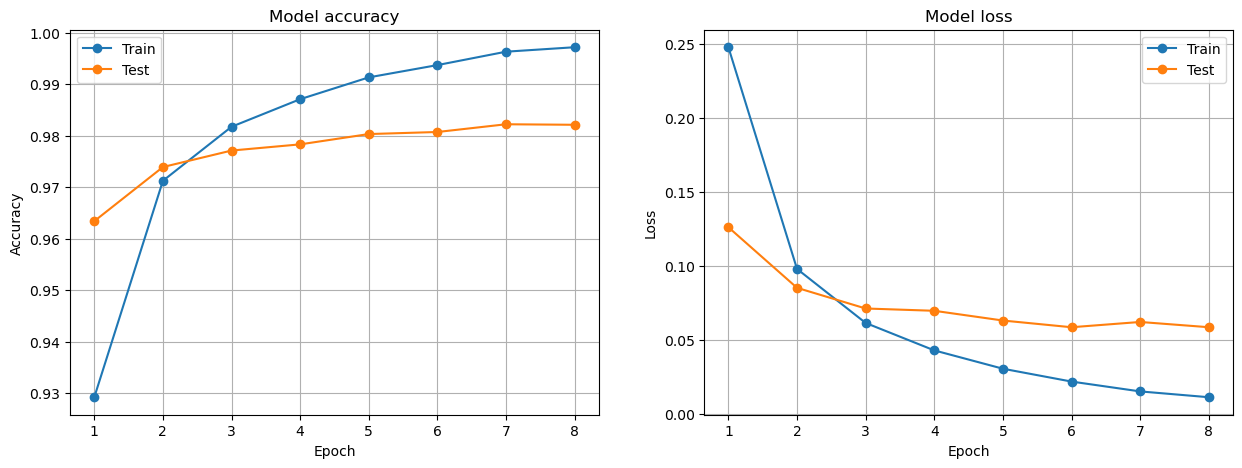

In [30]:
plot_loss_accuracy(hist)

## 8 - Save the structure & weights of the trained Network

The `save` method of the `Sequential` class saves **the structure** and the **weights** of the trained DNN.<br>
You can use later the `tf.keras.models.load_model` function to recreate the network and reload its trained weights to exploit it in operational situation.

In [31]:
import os

# Check wether the 'model' directory exist (create it if needed):
if not os.path.exists("models"): os.mkdir("models")

# define a uniq key:
key = 'dense1_trained'

# define the path where to store the network data:
path = os.path.join('models', key)

# savue the structure and the weights of the current neural network:
model.save(path)

# display the tree beginning at f'./models/{key}':
tree = scan_dir(f"./models/{key}")
print(f'\nFiles written:\n{tree}')    

INFO:tensorflow:Assets written to: models/dense1_trained/assets

Files written:
./models/dense1_trained/keras_metadata.pb
./models/dense1_trained/saved_model.pb
./models/dense1_trained/variables/variables.index
./models/dense1_trained/variables/variables.data-00000-of-00001
./models/dense1_trained/assets/



## 4 - Save the structure & weights of the initial Network

We can save the weights of the initial untrained network (random values) and its structure with the `model.save` method. <br>
This will be useful later to re-create the network to its initial state if we want to compare difrent trainings:

In [17]:
import os

# Check wether the 'model' directory exist (create it if needed):
if not os.path.exists("models"): os.mkdir("models")

# define a uniq key:
key = 'dense1_init'

# define the path where to store the network data:
path = os.path.join('models', key)

# savue the structure and the weights of the current neural network:
model.save(path)

# display the tree beginning at f'./models/{key}':
tree = scan_dir(f"./models/{key}")
print(f'\nFiles written:\n{tree}')    

INFO:tensorflow:Assets written to: models/dense1_init/assets

Files written:
./models/dense1_init/fingerprint.pb
./models/dense1_init/keras_metadata.pb
./models/dense1_init/saved_model.pb
./models/dense1_init/variables/variables.index
./models/dense1_init/variables/variables.data-00000-of-00001
./models/dense1_init/assets/



Note: the `save` method uses the `key` part of its argument to prefix the created file names.<br>
$\leadsto$ When loading the DNN structure & weights later with the `tf.keras.models.load_model` method, we just use the same key to retrieve the relevant files.